## File info: 
- This file contains exploratory data analysis performed on all the csv file present in folder `daily_data`

### Import statements

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import os
from pathlib import Path


### Read data

In [14]:
folder_path = Path.cwd().joinpath("daily_data")
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
dataframes = []

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

combined_data = pd.concat(dataframes, ignore_index=True)
print(f"dataset shape : {combined_data.shape}")
combined_data.head(5)

dataset shape : (40061, 5)


,venue_id,visitor_id,visit_start_time,visit_end_time,venue_type
0,UN004,V2940,2024-10-28 06:00:00.000000,2024-10-28 08:23:29.648705,university
1,UN003,V1337,2024-10-28 06:01:00.000000,2024-10-28 07:31:23.598391,university
2,UN000,V1933,2024-10-28 06:02:00.000000,2024-10-28 10:18:23.804368,university
3,UN003,V1543,2024-10-28 06:08:00.000000,2024-10-28 07:19:24.080107,university
4,UN002,V1389,2024-10-28 06:08:00.000000,2024-10-28 08:08:23.312124,university


### Insights

In [15]:
# Null values
combined_data.isna().sum()

venue_id              0
visitor_id            0
visit_start_time      0
visit_end_time      396
venue_type           92
dtype: int64

In [16]:
# Drop duplicate values
combined_data.drop_duplicates(keep='first', inplace=True)

In [17]:
# observations for each venue type
combined_data['venue_type'].value_counts()

venue_type
university      29286
coffee_place     8659
cinema           1789
unknown            38
Name: count, dtype: int64

In [18]:
# Unique venue_ids
combined_data['venue_id'].unique()

array(['UN004', 'UN003', 'UN000', 'UN002', 'UN001', 'CO000', 'CO002',
       'CO003', 'CO001', 'CO004', 'CI001', 'CI004', 'CI002', 'CI003',
       'CI000'], dtype=object)

### Handling columns 'visit_start_time' and 'visit_end_time'

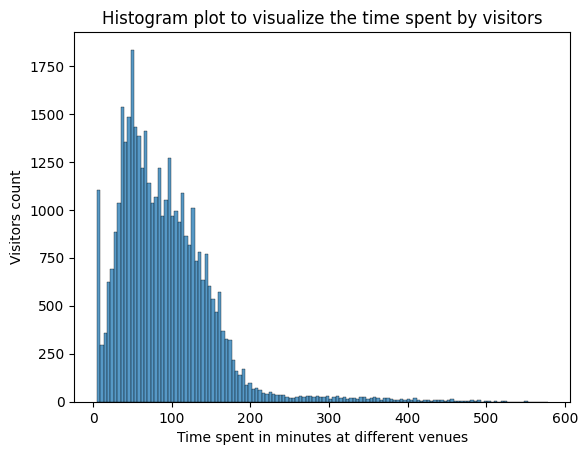

Median time spent by the visitor at venue: 81.0


In [19]:
combined_data['visit_end_time'] = pd.to_datetime(combined_data['visit_end_time'])
combined_data['visit_start_time'] = pd.to_datetime(combined_data['visit_start_time'])

combined_data['time_spent_minutes'] = abs(((combined_data['visit_end_time'] - combined_data['visit_start_time']).dt.total_seconds() / 60)).round()

sns.histplot(combined_data['time_spent_minutes'])
plt.xlabel('Time spent in minutes at different venues')
plt.ylabel('Visitors count')
plt.title('Histogram plot to visualize the time spent by visitors')
plt.show()
print(f"Median time spent by the visitor at venue: {combined_data['time_spent_minutes'].median()}")

### combine all files in daily_data

In [ ]:
def swap_times(row):
    if row['visit_start_time'] > row['visit_end_time']:
        row['visit_start_time'], row['visit_end_time'] = row['visit_end_time'], row['visit_start_time']
    return row

# Define the mapping of venue_id to venue_type
venue_mapping = {
    'UN': 'university',
    'CO': 'coffee place',
    'CI': 'cinema'
}

# Path to your folder containing CSV files
folder_path = Path.cwd().joinpath("daily_data")
final_result = pd.DataFrame()

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        print(file)
        file_name_date_value = pd.to_datetime(file.split('.')[0], format='%Y%m%d').date()
        file_path = os.path.join(folder_path, file)
        venue_data = pd.read_csv(file_path)
        venue_data.drop_duplicates(keep='first', inplace=True)

        venue_data['visit_end_time'] = pd.to_datetime(venue_data['visit_end_time'])
        venue_data['visit_start_time'] = pd.to_datetime(venue_data['visit_start_time'])
        venue_data['date'] = venue_data['visit_start_time'].dt.date
        venue_data['visit_end_time'] = venue_data['visit_end_time'].fillna(venue_data['visit_start_time'] + pd.Timedelta(minutes=81))

        if len(venue_data[venue_data['date'] == file_name_date_value]) == len(venue_data):
            print('All dates are equal')
        else:
            print(f'Discarded {len(venue_data) - len(venue_data[venue_data.date == file_name_date_value])} rows')

        venue_data[['visit_start_time', 'visit_end_time']] = venue_data.apply(swap_times, axis=1)
        venue_data['venue_type'] = venue_data['venue_type'].replace('unknown', np.nan)
        venue_data['venue_type'] = venue_data['venue_type'].fillna(venue_data['venue_id'].str[:2].map(venue_mapping))

        result = venue_data.groupby('venue_id').agg({
            'date': 'first',
            'visitor_id': ['nunique', 'count']
        }).reset_index()
        result.columns = ['venue_id', 'date', 'visitor_count_unique', 'visitor_count_total']
        result = result[['date', 'venue_id', 'visitor_count_unique', 'visitor_count_total']]
        final_result = pd.concat([final_result, result])

final_result.to_csv('pre_processed_venue_data.csv', header=True, index=False)

### line plots for each venue

In [20]:
forecasting_df = pd.read_csv('pre_processed_venue_data.csv')
VENUE_MAPPING = {"UN": "university", "CO": "coffee place", "CI": "cinema"}
forecasting_df['category'] = forecasting_df['venue_id'].apply(lambda x: VENUE_MAPPING[x[:2]])
# Plot the time series graph
fig = px.line(
    forecasting_df,
    x='date',
    y='visitor_count_total',
    color='category',
    title="Time Series of total visitors by venue",
    labels={'visitor_count_total': 'Total visitors', 'date': 'Date'}
)

fig.show()

In [21]:
# Plot the time series graph
fig = px.line(
    forecasting_df,
    x='date',
    y='visitor_count_total',
    color='venue_id',
    title="Time Series of total visitors by venue",
    labels={'visitor_count_total': 'Total visitors', 'date': 'Date'}
)

fig.show()

### ACF and PACF
- As all the venues under same category have similar pattern we take the mean visitor count to check ACF anf PACF for each category 

In [22]:
category_data = (
    forecasting_df.groupby(["category", "date"])["visitor_count_total"]
    .mean()
    .reset_index()
)
category_data['visitor_count_total'] = category_data['visitor_count_total'].apply(lambda x: math.ceil(x))

Category: cinema


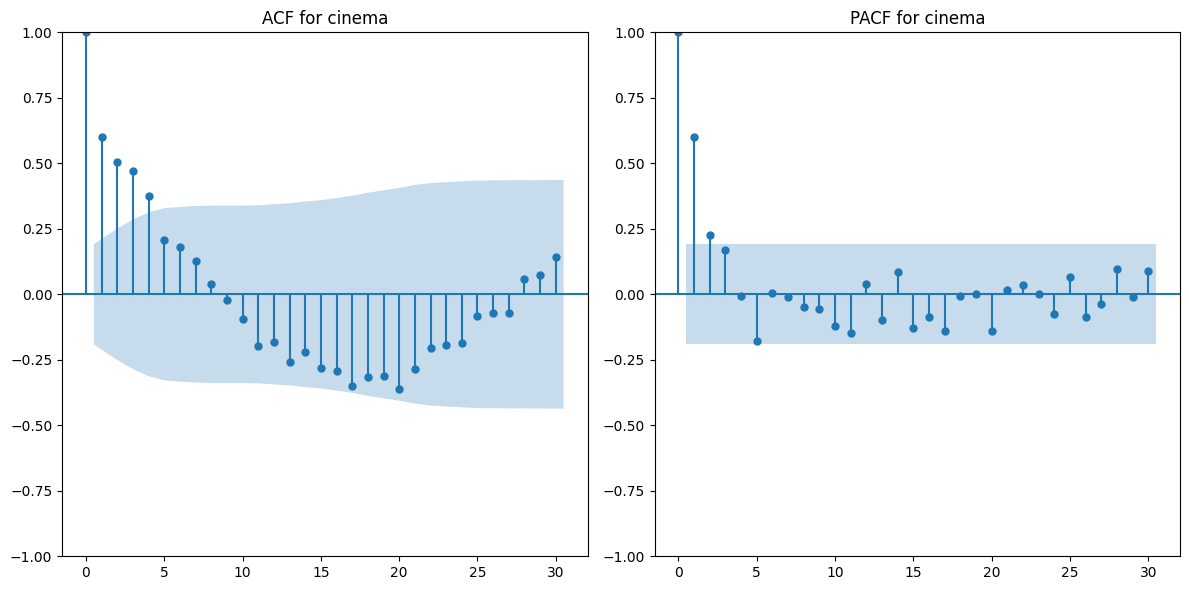

Category: coffee place


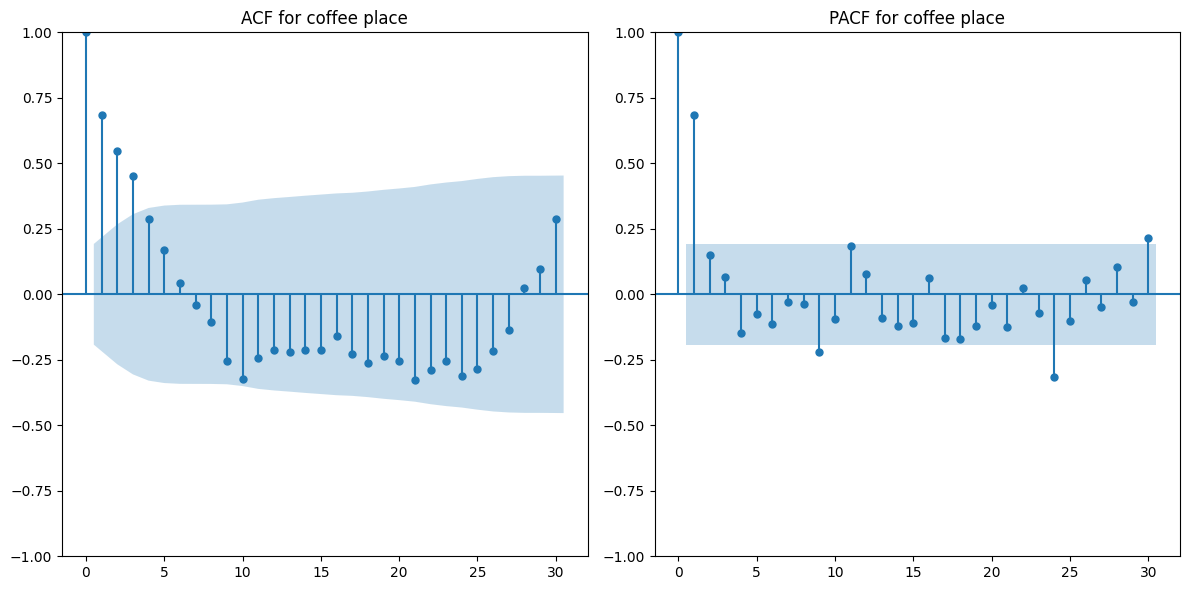

Category: university


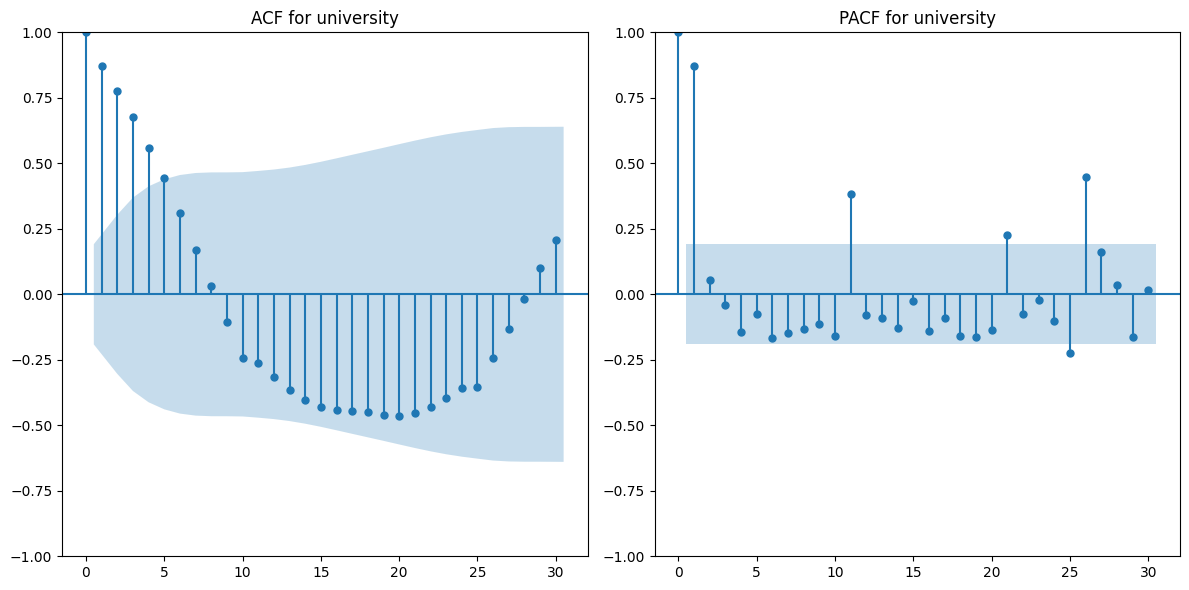

In [23]:
def plot_acf_pacf_for_category(data, category):
    category_data = data[data["category"] == category].set_index("date")["visitor_count_total"]
    
    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    plot_acf(category_data, ax=axes[0], lags=30, title=f"ACF for {category}")
    plot_pacf(category_data, ax=axes[1], lags=30, title=f"PACF for {category}")
    
    plt.tight_layout()
    plt.show()

# Loop through each category and plot
for category in forecasting_df["category"].unique():
    print(f"Category: {category}")
    plot_acf_pacf_for_category(forecasting_df, category)
